# Potresi

V projektni nalogi bom analizirala podatke o potresih od [tukaj](http://www.emsc-csem.org/) (European-Mediterranean Seismological Centre). Odločila sem se za potrese, ki so se zgodili v prvih dveh tednih oktobra (torej do 15. oktobra), ker da ta časovni okvir ravno pravšnje število podatkov - skoraj 2000 potresov.

Na navedeni strani najdete podatke o zadnjih potresih po svetu (podatke sicer pridobivajo avtomatsko od približno 70 opazovalnic, ki so večinoma v Evropi, zaznajo pa seveda potrese z vsega sveta) - na primer čas potresa, lokacijo (v koordinatah in opisno), globino in magnitudo. Kdorkoli lahko prispeva komentar oziroma fotografijo, če je potres začutil ali opazil posledice (recimo razpoke na hiši). Za posamezen potres, ki je pritegnil vašo pozornost, lahko pridobite ogromno podatkov, ki pa jih na tem mestu ne bomo obravnavali, ker za analizo niso posebej zanimivi.

#### Opomba

Če vas potresi zelo zanimajo, si oglejte tudi [to projektno nalogo](https://github.com/TinaKrasovec/Potresi-po-Evropi-zadnjih-nekaj-let-z-magnitudo-4). Podobnost je naključna, poskusili pa sva delati tako, da se analiza ne prekriva preveč. Pri delu nisva sodelovali.

## Uvod
Naložimo csv datoteko in si oglejmo nekaj vrstic za občutek.

In [1]:
import pandas as pd
pd.options.display.max_rows = 15


%matplotlib inline

In [2]:
podatki = pd.read_csv('potresi_potresi.csv', index_col = 'id')
podatki[:7]

,leto,mesec,dan,ura,minuta,sekunda,DOL,dolzina,SIR,sirina,globina,magnituda,regija
id,,,,,,,,,,,,,
537411,2016,10,15,23,40,55.1,E,34.31,N,38.13,4,2.7,CENTRAL TURKEY
538627,2016,10,15,23,40,50.0,W,176.29,N,52.52,178,3.2,"ANDREANOF ISLANDS, ALEUTIAN IS."
537458,2016,10,15,23,17,42.6,E,27.72,N,38.93,6,2.6,WESTERN TURKEY
537380,2016,10,15,23,6,59.1,E,20.69,N,39.76,15,4.3,GREECE
537552,2016,10,15,22,43,13.2,W,155.47,N,19.21,37,2.2,"ISLAND OF HAWAII, HAWAII"
537385,2016,10,15,22,35,29.3,E,27.69,N,38.94,8,3.6,WESTERN TURKEY
537310,2016,10,15,22,30,26.1,E,71.70,N,41.26,15,3.7,EASTERN UZBEKISTAN


## Kje so se zgodili potresi?

Večkrat smo že slišali, da živimo na potresno zelo živahnem območju. Izkaže pa se, da se v smislu potresov v začetku oktobra v Sloveniji ni veliko zgodilo. Opazovalnice so zabeležile en sam potres na našem območju, zato se najbrž spodobi, da ga izpišemo.

In [3]:
podatki[podatki.regija == 'SLOVENIA']

,leto,mesec,dan,ura,minuta,sekunda,DOL,dolzina,SIR,sirina,globina,magnituda,regija
id,,,,,,,,,,,,,
536262,2016,10,10,11,43,41.6,E,14.59,N,45.94,2,2.0,SLOVENIA


In [4]:
podatki.loc[536262]

leto             2016
mesec              10
dan                10
ura                11
minuta             43
sekunda          41.6
DOL                 E
dolzina         14.59
SIR                 N
sirina          45.94
globina             2
magnituda           2
regija       SLOVENIA
Name: 536262, dtype: object

Kako zanimivo! Potres se je zgodil v ponedeljek, 10. oktobra ob 11:43, ko so potekale vaje za programiranje.

Poskusimo ugotoviti, v katerih državah se je zgodilo največ potresov.

In [5]:
stevilo_regije = podatki['regija'].value_counts()
stevilo_regije

WESTERN TURKEY                      233
GREECE                               68
SOUTHERN ALASKA                      66
CENTRAL TURKEY                       64
OKLAHOMA                             59
EASTERN TURKEY                       57
CENTRAL ITALY                        54
                                   ... 
ARKANSAS                              1
NEAR S COAST OF CHUKOTKA, RUSSIA      1
EASTERN UZBEKISTAN                    1
PANAMA                                1
ST. LUCIA REGION, WINDWARD ISL.       1
OFFSHORE BAJA CALIFORNIA, MEXICO      1
TURKEY-SYRIA BORDER REGION            1
Name: regija, dtype: int64

Turčija je očitno potresno zelo zanimiva država, saj med prvimi petimi regijami nastopi kar trikrat s skupno več kot 350 potresi.

Opazimo pa tudi težavo. Sklepali bi, da so potresno aktivna območja deljena v manjše regije (kot zgoraj Turčija in Kalifornija) zato, da tisti, ki se s tem ukvarjajo, že na prvi pogled bolj natančno vedo, kje je bil potres. Recimo pa, da nas ne zanima, v katerem delu države se je potres zgodil, ampak samo država, ker bodo v tem primeru podatki preglednejši.

### Funkcija, ki regijo spremeni v državo

Spodnja funkcija iz regije približno naredi državo (tabeli dodamo stolpec "drzava"). Zakaj samo približno? Ime regije je zapisano v več oblikah in manjšinski del teh opisov funkcija ohrani, čeprav niso idealni. Spodaj je za vsako obliko napisano, kaj funkcija pretvori_v_drzavo z njo naredi:

- imenovanje regije s stranmi neba (zahodna, osrednja, jugovzhodna ...): V tem primeru ohranimo samo ime države
- enako kot zgoraj, samo da je namesto cele besede uporabljena le prva črka (W, E, S, N): Pobrišemo črko
- zapis oblike 'mesto/pokrajina, država': V tem primeru zbrišemo vse pred vejico
- širše območje neke države (predpostavljam, da gre za otočja), npr 'FIJI REGION': ohranimo samo ime države
- čudne izjeme (CALIF., N.Z., P.N.G) - čudne zato, ker se poleg teh kratic pojavljajo tudi običajna dolga imena držav: Spremenimo v dolgo ime države.
- območje na morju ('OFFSHORE ...' ali 'NEAR THE COAST OF ...'): Izbrišemo opis območja
- namesto 'ISLANDS' piše 'IS.' (tega ne bi popravljali, če ne bi pri isti državi opazili obeh načinov zapisovanja): Spremenimo v 'ISLANDS'

En opis, ki ga nisem popravljala, je recimo mejno območje med dvema državama (kot recimo 'CHINA-LAOS BORDER REG'). Dobiti stoplec, ki bi vseboval izključno samo države, pa je iz teh podatkov skoraj nemogoče, saj v stolpcu regija najdemo tudi Pireneje, gorovje med Španijo in Francijo, in Afriko (res!). Tega ne moremo popraviti z nobeno funkcijo.

In [6]:
def pretvori_v_drzavo(reg):
    odvec = {'WESTERN' : 8, 'EASTERN' : 8, 'CENTRAL' : 8, 'SOUTHERN' : 9, 'NORTHERN' : 9, 'OFFSHORE' : 9, 
             'NEAR' : 5, 'REGION' : -7, 'PENINSULA' : -10, 'GULF' : 8, 'SOUTH' : 6, 'WEST' : 5, 
             'EAST' : 5, 'NORTH' : 6, 'THE' : 4, 'COAST' : 6, 'OF' : 3, 'OFF' : 4, 'SOUTHEAST' : 10,
             'SOUTHWEST' : 10, 'NORTHEAST' : 10, 'NORTHWEST' : 10, 'RISE' : -5, 'RIDGE' : -6}
    
    cudne_izjeme = {'CALIF.' : 'CALIFORNIA', 'N.Z.' : 'NEW ZEALAND', 'P.N.G.' : 'PAPUA NEW GUINEA'}
    
    if ' ' in reg:
        zacetek = reg[:reg.index(' ')]           # Izrežemo prvo besedo (od začetka do prvega presledka).
        konec = reg[-(reg[::-1].index(' ')):]    # Izrežemo zadnjo besedo (od konca do zadnjega presledka).
    elif reg in cudne_izjeme:
        return cudne_izjeme[reg]
    else:
        return reg
    
    if ',' in reg:
        vejica = reg.index(',')
        nova_regija = reg[vejica + 2:]
        return pretvori_v_drzavo(nova_regija)
    elif len(zacetek) == 1:                       # Če je prva črka W, E, S ali N.
        nova_regija = reg[2:]
    elif zacetek in odvec:
        nova_regija = reg[odvec[zacetek]:]
        return pretvori_v_drzavo(nova_regija)
    elif konec in odvec:
        nova_regija = reg[:odvec[konec]]
        return pretvori_v_drzavo(nova_regija)
    elif konec == 'IS.':
        return reg[:-1] + 'LANDS'
    else:
        return reg

In [7]:
podatki['drzava'] = podatki['regija'].map(pretvori_v_drzavo)
podatki[:7]

,leto,mesec,dan,ura,minuta,sekunda,DOL,dolzina,SIR,sirina,globina,magnituda,regija,drzava
id,,,,,,,,,,,,,,
537411,2016,10,15,23,40,55.1,E,34.31,N,38.13,4,2.7,CENTRAL TURKEY,TURKEY
538627,2016,10,15,23,40,50.0,W,176.29,N,52.52,178,3.2,"ANDREANOF ISLANDS, ALEUTIAN IS.",ALEUTIAN ISLANDS
537458,2016,10,15,23,17,42.6,E,27.72,N,38.93,6,2.6,WESTERN TURKEY,TURKEY
537380,2016,10,15,23,6,59.1,E,20.69,N,39.76,15,4.3,GREECE,GREECE
537552,2016,10,15,22,43,13.2,W,155.47,N,19.21,37,2.2,"ISLAND OF HAWAII, HAWAII",HAWAII
537385,2016,10,15,22,35,29.3,E,27.69,N,38.94,8,3.6,WESTERN TURKEY,TURKEY
537310,2016,10,15,22,30,26.1,E,71.70,N,41.26,15,3.7,EASTERN UZBEKISTAN,UZBEKISTAN


### Delo z novim stolpcem

Izpišimo torej število potresov glede na novi stolpec 'drzava' in se prepričajmo, da je bilo pisanje funkcije in dodajanje stoplca smiselno. Res, vrh seznama se opazno spremeni, čeprav Turčija ostaja daleč pred ostalimi državami. Za prvih 20 držav bomo spodaj izrisali tudi graf.

In [8]:
stevilo_drzava = podatki['drzava'].value_counts()
stevilo_drzava

TURKEY                    368
ALASKA                    202
CHILE                     165
CALIFORNIA                134
GREECE                    133
ALEUTIAN ISLANDS           73
ITALY                      67
                         ... 
MOZAMBIQUE                  1
ADEN                        1
WINDWARD ISL.               1
SANDWICH ISLANDS            1
XIZANG                      1
GEORGIA (SAK'ART'VELO)      1
ARIZONA                     1
Name: drzava, dtype: int64

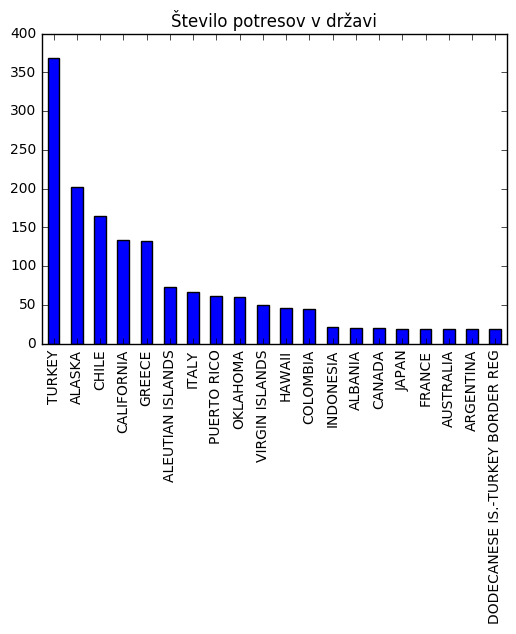

In [9]:
stevilo_drzava.head(20).plot(kind='bar', title='Število potresov v državi')

Izpišimo potrese z največjo magnitudo, saj nas ta podatek običajno zelo zanima. Najprej izpišimo posamezne najmočnejše potrese, ki so se zgodili v prvi polovici oktobra. Zanimivo je, da držav s prejšnjega grafa v tej tabeli skoraj ni (izjemi sta npr. Japonska in Indonezija). Videti je, da se v državah z največ potresi niso zgodili najmočnejši potresi.

Sklepamo torej, da bi si bilo pametno ogledati tudi tabelo s povprečno magnitudo, ki jo bomo izpisali spodaj.

In [10]:
delno = podatki[['regija', 'drzava', 'magnituda']]
delno.sort_values('magnituda', ascending=False)[:15]

,regija,drzava,magnituda
id,,,
537136,"NEW BRITAIN REGION, P.N.G.",PAPUA NEW GUINEA,6.3
536567,"NEW IRELAND REGION, P.N.G.",PAPUA NEW GUINEA,5.8
536094,"HALMAHERA, INDONESIA",INDONESIA,5.8
535332,CENTRAL MID-ATLANTIC RIDGE,MID-ATLANTIC,5.7
535475,TAIWAN REGION,TAIWAN,5.7
535099,"BONIN ISLANDS, JAPAN REGION",JAPAN,5.7
534730,"LUZON, PHILIPPINES",PHILIPPINES,5.7
534730,"LUZON, PHILIPPINES",PHILIPPINES,5.7
535512,CENTRAL EAST PACIFIC RISE,PACIFIC,5.6


### Razna povprečja

Sedaj si oglejmo še povprečne magnitude. Opazimo, da se pojavijo mnoge države iz zgornje tabele. Kako bi si to razložili?

Na rezultate gotovo vpliva relativno majhno skupno število podatkov in izredno velik razpon v številu podatkov za posamezno državo. Zato teh povprečnih vrednosti ne smemo jemati preresno. Opozorila bi recimo na primer Pacifika (če zanemarimo očitno težavo, da to ni država). Sklepali bi, da se je tam v opazovanem času zgodil le en izredno močan potres (magnituda 5.6 v zgornji tabeli je enaka povprečju za Pacifik spodaj). Spodaj smo to preverili - res, najdemo le en potres za to "državo". 

In [11]:
drzave = podatki.groupby('drzava')

drzave['magnituda'].mean().sort_values(ascending=False).round(2)[:15]

drzava
PACIFIC              5.60
EASTER ISLAND        5.35
TAIWAN               5.25
MID-ATLANTIC         5.25
BLACK SEA            5.20
TONGA                5.10
PAPUA NEW GUINEA     5.05
BOUVET ISLAND        5.00
MARIANA ISLANDS      5.00
KERMADEC ISLANDS     5.00
SAMOA ISLANDS        5.00
PACIFIC-ANTARCTIC    5.00
SANDWICH ISLANDS     5.00
BALLENY ISLANDS      5.00
ATLANTIC OCEAN       4.90
Name: magnituda, dtype: float64

In [12]:
podatki[podatki.drzava == 'PACIFIC']

,leto,mesec,dan,ura,minuta,sekunda,DOL,dolzina,SIR,sirina,globina,magnituda,regija,drzava
id,,,,,,,,,,,,,,
535512,2016,10,6,20,57,8.0,W,104.03,S,4.06,10,5.6,CENTRAL EAST PACIFIC RISE,PACIFIC


Izkoristimo še stolpca 'DOL' in 'SIR', ki vsebujeta podatke o geografski širini in dolžini, in sicer samo vrednosti N, S, E, W za strani neba. Spodnji graf prikazuje, kolikšen delež zaznanih potresov se je zgodil na severni in južni polobli. Porazdelitev je presenetljiva, saj za tako nenavadno razmerje navidez ni vzroka.

Zakaj pa nas ti podatki vendale ne presenečajo tako zelo? EMSC (vir podatkov) je evropska mreža. Kot sem zapisala v uvodu, je večina opazovalnic v Evropi, kar pomeni, da z večjo natančnostjo zaznajo tudi manj močne potrese na tem območju (in podatke posredujejo EMSC). Drugače povedano - šibak potres npr. v Švici bo zabeležen, enako močan v Južnoafriški republiki pa ne, ker ga evropske opazovalnice ne bodo zaznale (predpostavimo, da recimo nobena bližnja opazovalnica ni vključena v mrežo). Drug faktor je porazdelitev kopnega - tudi če bi bile EMSC-jeve opazovalnice enakomerno razporejene po svetu, je na južni polobli pač manj kopnega in posledično manj opazovalnic.

Podatki o mediani in povprečni magnitudi potrjujejo zgoraj zapisano - tisti potresi z južne poloble, ki so jih zaznali, so bili močnejši, posledično sta prikazani vrednosti višji.

Pri delitvi vzhod-zahod so razultati dosti bližje pričakovani porazdelitvi (približno pol-pol).

(SIR
 N    2.4
 S    3.7
 Name: magnituda, dtype: float64, SIR
 N    2.61
 S    3.71
 Name: magnituda, dtype: float64)

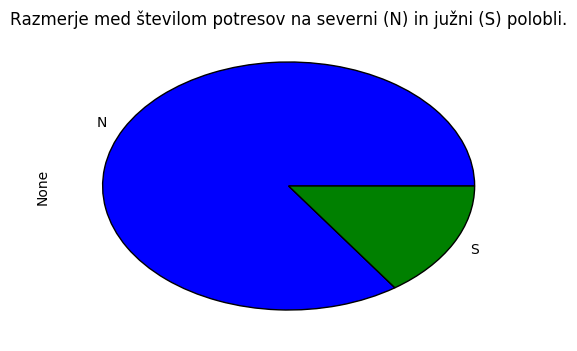

In [13]:
sirina = podatki.groupby('SIR')
sirina.size().plot(kind = 'pie', title = 'Razmerje med številom potresov na severni (N) in južni (S) polobli.')

sirina['magnituda'].median(), sirina['magnituda'].mean().round(2)

(DOL
 E    2.4
 W    2.5
 Name: magnituda, dtype: float64, DOL
 E    2.76
 W    2.80
 Name: magnituda, dtype: float64)

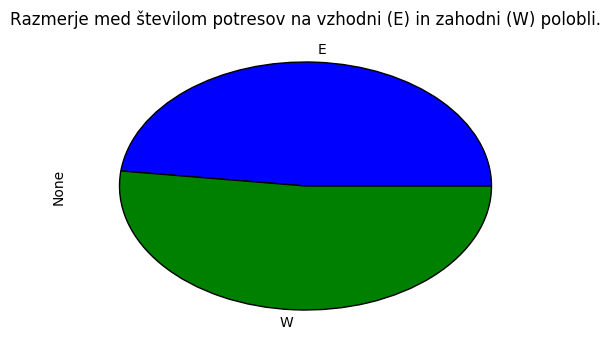

In [14]:
dolzina = podatki.groupby('DOL')
dolzina.size().plot(kind = 'pie', title = 'Razmerje med številom potresov na vzhodni (E) in zahodni (W) polobli.')

dolzina['magnituda'].median(), dolzina['magnituda'].mean().round(2)

Glede na to, da smo že opazili, da zaradi držav s premalo potresi včasih dobimo nekoliko zavajajoče rezultate, si morda oglejmo še, kako "razgibana" je neka država. Merilo bo zelo preprosto - od potresa z največjo magnitudo odštejemo tistega z najmanjšo. S tem podatkom dobimo neko dodatno informacijo o posameznem območju.

Če se spomnimo grafa, ki je prikazoval število potresov v posamezni državi, nas visoko uvrščene države ne presenečajo (prvih šest držav je istih, samo v drugačnem vrstnem redu). Kot zanimivost pa si poglejmo še podatke o številu potresov v Norveškem morju, na Hrvaškem in v Mehiki. (Pričakujemo nizko skupno število potresov.)

In [15]:
razgibanost = drzave['magnituda'].max() - drzave['magnituda'].min()
razgibanost.sort_values(ascending=False).head(10)

drzava
GREECE              3.4
CALIFORNIA          3.3
ALASKA              3.3
CHILE               2.8
ALEUTIAN ISLANDS    2.7
TURKEY              2.7
NORWEGIAN SEA       2.6
CROATIA             2.6
MEXICO              2.5
ITALY               2.4
Name: magnituda, dtype: float64

In [16]:
stevilo_drzava['NORWEGIAN SEA'], stevilo_drzava['CROATIA'], stevilo_drzava['MEXICO']

(2, 3, 15)

### Spremenimo zapis koordinat tako, da bomo z njimi lahko kaj počeli

Sedaj podatkom dodajmo dva nova stolpca, ki bosta uporabna za raziskovanje, kje (po koordinatah) so se dogajali potresi. Težava z obstoječimi podatki je bila, da iz stolpcev 'sirina' in 'dolzina' ni bilo razvino, kje natanko se je potres zgodil (npr. Egipt in Južna Afrika imata približno enako zemljepisno širino, Portugalska in Korzika pa dolžino), kar onemogoča analizo. Krajem, ki so južno od ekvatorja ali zahodno od Greenwicha, pred vrednost zapišemo minus v skladu s standardnim označevanjem v geografiji. Ker bomo delali s povprečnimi vrednostmi, podatke sproti še zaokrožimo na število, deljivo s 5.

Spodaj je prikazanih nekaj vrstic, kjer lahko primerjamo stara stoplca z novima.

In [17]:
def predznak(x):
    if x == 'W' or x == 'S':
        return (-1)
    else:
        return 1

In [18]:
podatki['dolzina_prava'] = podatki['DOL'].map(predznak) * podatki['dolzina']
podatki['dolzina_prava'] = round(podatki['dolzina_prava']*2, -1) / 2     # Zaokrožimo.

podatki['sirina_prava'] = podatki['SIR'].map(predznak) * podatki['sirina']
podatki['sirina_prava'] = round(podatki['sirina_prava']*2, -1) / 2       # Zaokrožimo.


podatki[['DOL', 'dolzina', 'SIR', 'sirina', 'magnituda', 'drzava', 'dolzina_prava', 'sirina_prava']][32:36]

,DOL,dolzina,SIR,sirina,magnituda,drzava,dolzina_prava,sirina_prava
id,,,,,,,,
537855,E,167.20,S,12.31,4.6,SANTA CRUZ ISLANDS,165.0,-10.0
537543,E,71.28,N,37.00,4.3,AFGHANISTAN,70.0,35.0
537461,E,30.05,N,38.97,3.0,TURKEY,30.0,40.0
537472,W,68.73,S,22.13,2.6,CHILE,-70.0,-20.0


### Interpretacija grafov

Najprej si oglejmo porazdelitev potresov (opazujemo samo skupno število dogodkov) v smeri vzhod-zahod. Če imamo v mislih graf držav z največ potresi, lahko skoraj vsakemu vrhu pripišemo državo in ga nekako "osmislimo".

Sklepamo takole:

Vrhova skrajno desno pripadata Aleutskim otokom (vulkansko otočje med ameriško Aljasko in Rusko Kamčatko), vrh pri -150 pripada Aljaski, vrh med -150 in -100 pa Kaliforniji. Čile se nahaja približno pri -70, kar pojasni tamkajšnji vrh. 
Zelo očitno je, da najvišji in najširši vrh pripada Evropi - natančneje Grčiji (med 20 in 25) in Turčiji (med 25 in 45).

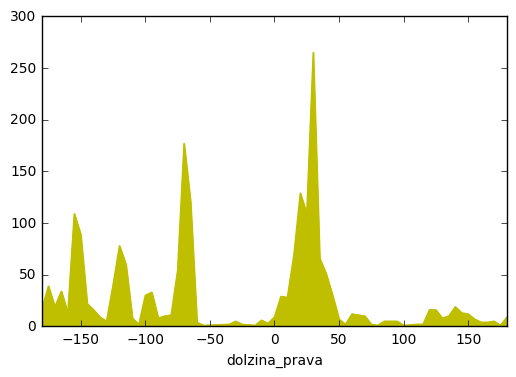

In [19]:
dolzina = podatki.groupby('dolzina_prava')
dolzina.size().plot(kind='area', color='y')

Podobno analizirajmo še smer sever-jug. Zanimivo je, da pri polih opazimo skoraj popoln upad zaznanih potresov. To je v skladu z razmislekom pri tortnih diagramih - površen pogled na zemljevid sveta na primer pokaže, da pod -40 (torej 40 stopinj južno od ekvatorja) praktično ni drugega kot morje (in seveda Antarktika), torej tudi zelo malo opazovalnic.

Za tokratne vrhove je razmislek približno takšen:

Za prve vrhove je kriv Čile, okrog 40 pa se nahajajo Kalifornija, Grčija, Turčija, Italija. Pri 60 nam ostanejo še Aljaska in Aleutski otoki.

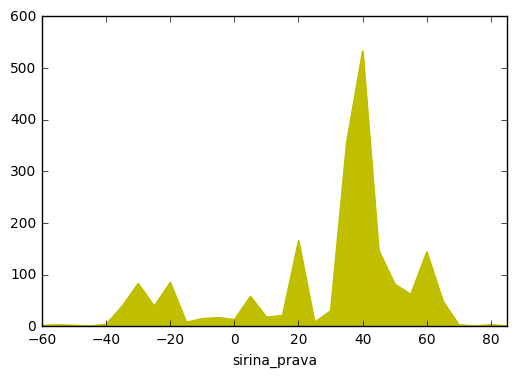

In [20]:
sirina = podatki.groupby('sirina_prava')
sirina.size().plot(kind='area', color='y')

## Kdaj so se zgodili potresi?

Osnovna hipoteza je, da so potresi bolj ali manj časovno neodvisni pojavi, zato povsod pričakujemo enakomerne porazdelitve - tako glede na dan v mesecu kot na primer glede na uro v dnevu.

Za začetek narišimo graf števila zaznanih potresov za vsak dan, ob tem si oglejmo še mediane vrednosti magnitud. Kot smo pričakovali, velikih odstopanj ni. Jasno je, da bi lepše (torej enakomernejše) grafe dobili z večjim številom zajetih podatkov.

Kot zanimivost pri prvem grafu morda omenimo razliko med dnevom 1 in 8. Prvega oktobra se je torej zgodilo le pol toliko potresov kot osmega, kar pa je seveda zgolj naključje.

(133.0, dan
 1     3.08
 2     2.76
 3     2.79
 4     2.85
 5     2.98
 6     2.73
 7     2.84
 8     2.79
 9     2.72
 10    2.68
 11    2.55
 12    2.78
 13    2.67
 14    2.80
 15    2.85
 Name: magnituda, dtype: float64)

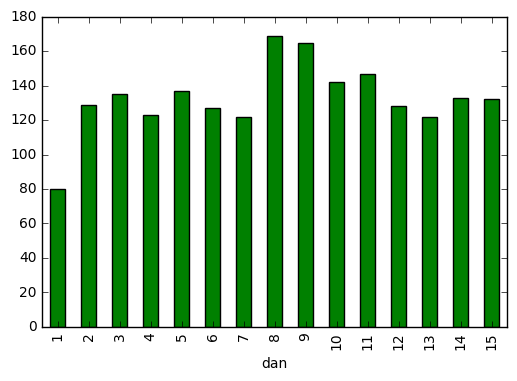

In [21]:
po_dnevu = podatki.groupby('dan')
po_dnevu.size().plot(kind='bar', color='g')
po_dnevu.size().mean().round(), po_dnevu['magnituda'].mean().round(2)

Recimo, da nas zanima razporeditev čez dan, torej po urah, in (bolj zaradi radovednosti) še znotraj ure, torej glede na minute. Prvi graf pokaže, koliko potresov se je zgodilo ob neki uri, povprečje je 83. 

(<matplotlib.axes._subplots.AxesSubplot at 0x7c28250>, 83.0)

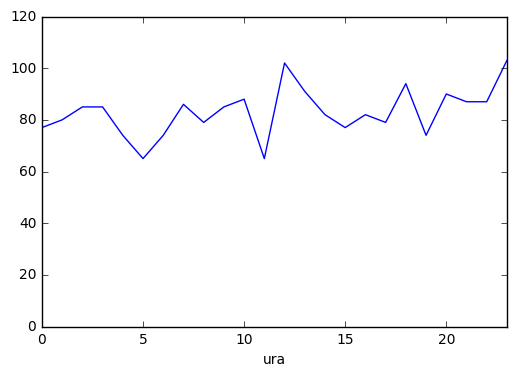

In [22]:
po_uri = podatki.groupby('ura')
po_uri.size().plot(ylim=(0, 120)), po_uri.size().mean().round()   # Smiselno prilagodimo y-os.

Izrišimo še graf, ki prikaže razporeditev znotraj ure. Kot pričakovano, so vrednosti blizu skupaj in nihajo okrog povprečja, ki je 33 potresov.

(<matplotlib.axes._subplots.AxesSubplot at 0x7bfb330>, 33.0)

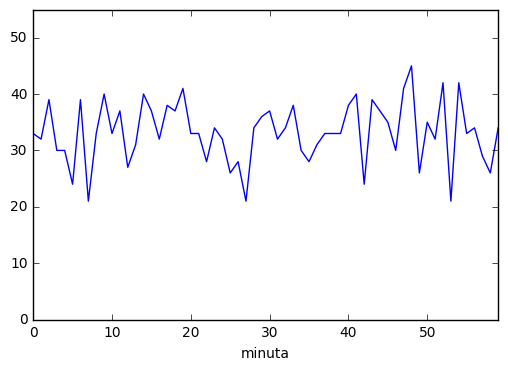

In [23]:
po_minuti = podatki.groupby('minuta')
po_minuti.size().plot(kind='line', ylim=(0, 55)), po_minuti.size().mean().round()  
# Smiselno prilagodimo y-os.

## Zaključimo z globino

Na hitro poglemo še povezavo globina-magnituda. Ali drži, da so tisti potresi, ki izvirajo iz večje globine, močnejši?

Prva stvar, ki se je moramo zavedati, je, da so naši potresi izrazito neenakomerno razporejeni (glede na globino in magnitudo). To pokaže spodnji graf, kjer vidimo, da se je velianska večina potresov zgodila na globini, manjši od 50 km. (Metodološki opazki: 
a) zabeleženi so tudi potresi na globini 0, 
b) najmanjša možna magnituda je 1.5, potresov z manjšo magnitudo ni v tej bazi podatkov)

Še en graf nižje smo prešteli potrese z določeno magnitudo - večino uvrstimo med 2 in 3.

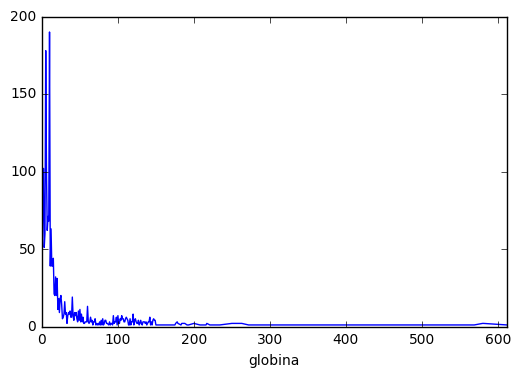

In [24]:
globina = podatki.groupby('globina')
globina.size().plot()

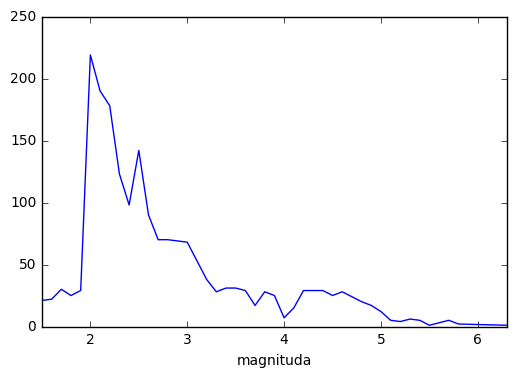

In [25]:
magnituda = podatki.groupby('magnituda')
magnituda.size().plot()

Zdaj pa vse to združimo v en veličasten graf. Spodaj vidimo graf, kjer smo vsakemu od skoraj 2000 potresov priredili piko glede na magnitudo (x-os) in globino (y-os). Seveda se mnoge pike prekrivajo, pa vendar lahko ob tem grafu povemo dosti stvari. Recimo:

- Da se močni potresi zgodijo le na veliki globini, ni res. Vidimo, da imajo potresi z globino 0 (torej blizu površja Zemlje) magnitude vse tja do 6.
- Potresi, ki se zgodijo zelo globoko, so močnejši. Vsi potresi z globino več kot 400 so imeli magnitudo nad 4.
- Šibki potresi se zgodijo blizu površja. Opazimo, da so potresi z magnitudo manj kot 2 imeli globino manj kot 50 km.

Res pa je, da so zgornje opazke vezane na dane podatke, ki jih ni dovolj za resno raziskovanje. Zato verjetno ne zgrešimo preveč, če zaključimo, da med globino in magnitudo potresa ni neke jasne nedvoumne povezave.

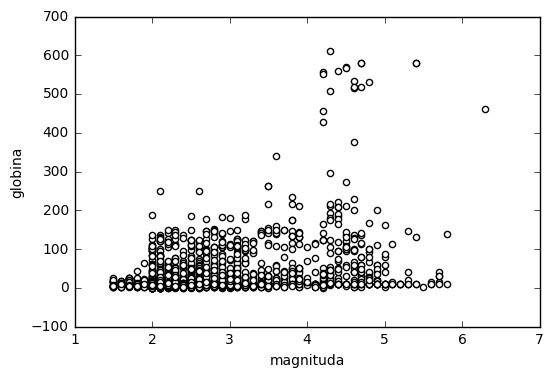

In [26]:
globinamagnituda = pd.DataFrame(podatki[['magnituda', 'globina']])   
globinamagnituda.plot(kind='scatter', x = 'magnituda', y = 'globina', color='w')

## Dodatek

Za konec dodajam "profile" držav z največ potresi (vrstni red: Turčija, Aljaska, Čile, Kalifornija in Grčija). Spomnila bi, da je bila Grčija prva po "razgibanosti" (sledila je Kalifornija). Grafe sem dobila tako, da sem iz zgornjega grafa belih pik izbrala le tiste pike, ki pripadajo posamezni državi, v naslovu pa je poleg imena države še skupno število potresov.

Seveda mi ne bi bilo treba dodati vseh petih grafov, ampak mi je ta 'scatter' tip grafa zelo všeč :) Poleg tega seveda, da se mi zdi, da res dobro predstavi situacijo v neki državi - bolj nazorno kot razna povprečja. Vsi grafi obsegajo območje do magnitude 6 in globine 275 km, da jih je lažje primerjati med seboj.

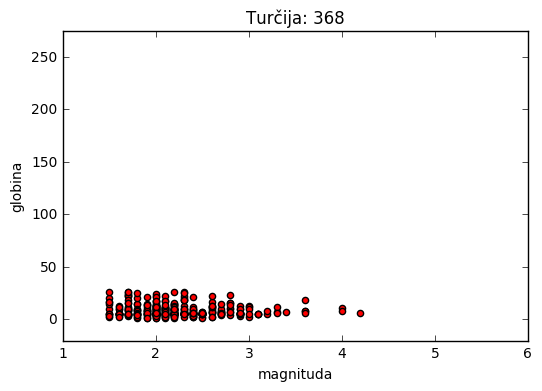

In [27]:
turcija = globinamagnituda[podatki.drzava == 'TURKEY']
turcija.plot(kind='scatter', x = 'magnituda', y = 'globina', xlim = (1, 6), ylim = (-20, 275), color = 'r', title='Turčija: 368')

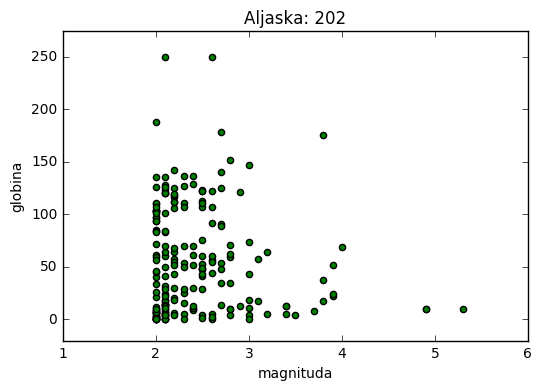

In [28]:
aljaska = globinamagnituda[podatki.drzava == 'ALASKA']
aljaska.plot(kind='scatter', x = 'magnituda', y = 'globina', xlim = (1, 6), ylim = (-20, 275), color = 'g', title='Aljaska: 202')

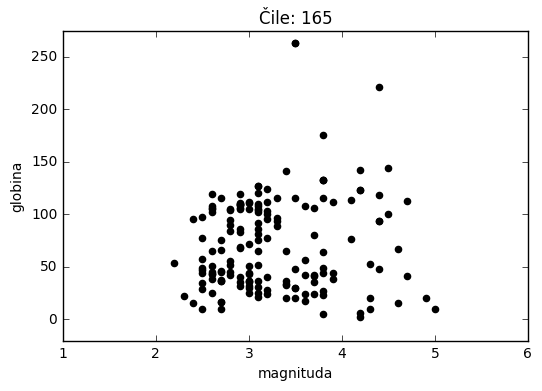

In [29]:
cile = globinamagnituda[podatki.drzava == 'CHILE']
cile.plot(kind='scatter', x = 'magnituda', y = 'globina', xlim = (1, 6), ylim = (-20, 275), color = 'k', title='Čile: 165')

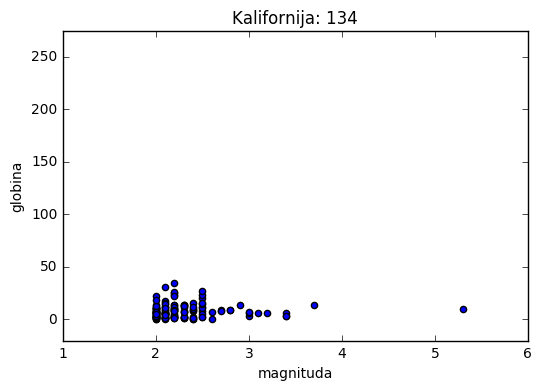

In [30]:
kalifornija = globinamagnituda[podatki.drzava == 'CALIFORNIA']
kalifornija.plot(kind='scatter', x = 'magnituda', y = 'globina', xlim = (1, 6), ylim = (-20, 275), color = 'b', title='Kalifornija: 134')

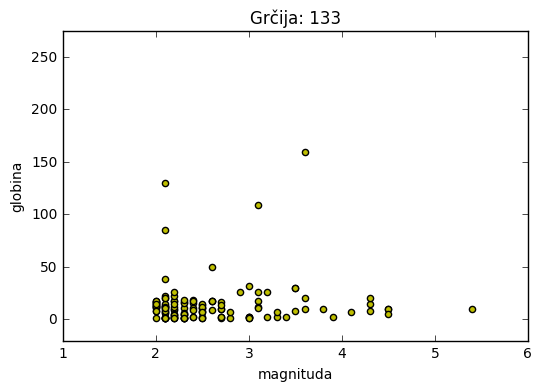

In [31]:
grcija = globinamagnituda[podatki.drzava == 'GREECE']
grcija.plot(kind='scatter', x = 'magnituda', y = 'globina', xlim = (1, 6), ylim = (-20, 275), color = 'y', title='Grčija: 133')